 ![alt text](https://s1.hostingkartinok.com/uploads/images/2024/01/0d0daf7820de38969ea92f79a5d590ac.jpg)



In [1]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as  nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
import time
from tqdm.autonotebook import tqdm, trange
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

companies = ['GAZP', 'SBER', 'LKOH', 'GMKN', 'MGNT',
       'TATN', 'NVTK', 'SNGS', 'PLZL', 'SNGSP',
       'PIKK', 'ROSN', 'SBERP', 'CHMF', 'NLMK',
       'IRAO', 'YNDX', 'ALRS', 'RUAL', 'MTSS',
       'MAGN', 'PHOR', 'RTKM', 'VTBR', 'TATNP',
       'TCSG', 'AGRO', 'OZON', 'AFLT', 'AFKS',
       'FEES', 'TRNFP', 'CBOM', 'VKCO', 'ENPG',
       'SGZH', 'FIVE', 'POLY', 'MOEX', 'GLTR',
       'HYDR', 'FIXP']

/tmp/ipykernel_43645/3897907851.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [13]:
path = '~/Рабочий стол/ДИПЛОМ НОУТБУКИ/DL forcasitng diplom/Данные Мосбиржа/Total_MOEX_(NEWEST)hourly_with_time_df'
total_df = pd.read_csv(path, index_col='tradedate')

# total_df.tradetime = total_df.close
# total_df.drop(['close', 'pr_close'], 1, inplace = True)
# total_df.rename(columns={'tradetime':'close'}, inplace=True)

In [14]:
data = total_df[total_df.secid == 'SBER'].drop('secid', 1)#.set_index('tradedate')

/tmp/ipykernel_43645/4178699835.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = total_df[total_df.secid == 'SBER'].drop('secid', 1)#.set_index('tradedate')


In [15]:
# train_data = data[ : round(data.shape[0]*0.53) ]
# val_data = data[ round(data.shape[0]*0.60) : ]

train_data = data[ : round(data.shape[0]*0.80) ].to_numpy()

val_data = data[ round(data.shape[0]*0.80) : ].to_numpy()

In [16]:
for i in range(data.shape[1]):
    if i == 0:
        train_series = train_data[:,i].reshape(-1, 1)
        val_series = val_data[:,i].reshape(-1, 1)
    
        scaler_star = StandardScaler()
        train_series = scaler_star.fit_transform(train_series)
        val_series = scaler_star.transform(val_series)
    
        train_data[:, i] = train_series.flatten()
        val_data[:, i] = val_series.flatten()
    
    elif i != 0:
        train_series = train_data[:,i].reshape(-1, 1)
        val_series = val_data[:,i].reshape(-1, 1)
        
        scaler = StandardScaler()
        train_series = scaler.fit_transform(train_series)
        val_series = scaler.transform(val_series)
        
        train_data[:, i] = train_series.flatten()
        val_data[:, i] = val_series.flatten()

In [17]:
train_data1 = train_data[ : round(data.shape[0]*0.53) ]
train_data2 = train_data[ round(data.shape[0]*0.60) : round(data.shape[0]*0.80) ]

In [47]:
def sample_creator(df, lookback, horizon):
    """
    Функция нарезает данные скользящим окном, 
    lookback=исторический промежуток
    horizon=горизонт прогнозирования
    !Внимание! target переменная должна стоять в первом столбце!
    """
    X = []
    Y = np.array([np.zeros(horizon) for i in range(lookback, df.shape[0]-horizon+1 )])
    
    for i in range(lookback, df.shape[0]-horizon+1):
        x = df[i-lookback : i, :]
        X.append(x)
        y = df[i:i+horizon, 0]
        Y[i-lookback] += y
        
        
    X = torch.Tensor(np.array(X))
    Y = torch.Tensor(Y)
    return X, Y

In [19]:
# lookback = 104
# horizon = 1

# x_train, y_train = sample_creator(train_data, lookback, horizon)
# x_val, y_val = sample_creator(val_data, lookback, horizon)

# print(f'x_train: {x_train.shape}, y_train: {y_train.shape}\nx_val: {x_val.shape}, y_val: {y_val.shape}')


# train_dataset = TensorDataset(x_train, y_train)
# val_dataset  = TensorDataset(x_val, y_val)

# train_loader = DataLoader(train_dataset, batch_size=150, shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=150, shuffle=False)

lookback = 34
horizon = 1

x_train1, y_train1 = sample_creator(train_data1, lookback, horizon)
x_train2, y_train2 = sample_creator(train_data2, lookback, horizon)
x_val, y_val = sample_creator(val_data, lookback, horizon)

x_train= torch.Tensor( np.concatenate([x_train1, x_train2]) )
y_train = torch.Tensor( np.concatenate([y_train1, y_train2]) )

train_dataset = TensorDataset(x_train, y_train)
val_dataset  = TensorDataset(x_val, y_val)                          


train_loader = DataLoader(train_dataset, batch_size=150, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=150, shuffle=False)

print(f'x_train: {x_train.shape}, y_train: {y_train.shape}\nx_val: {x_val.shape}, y_val: {y_val.shape}')

x_train: torch.Size([6057, 34, 57]), y_train: torch.Size([6057, 1])
x_val: torch.Size([1644, 34, 57]), y_val: torch.Size([1644, 1])


In [20]:
def winrate(y_true, y_pred):
    '''
    Входной формат: BatchSize*horizon(1)
    Выводит усреднённое число угаданных направлений по всему горизонту прогнозирования
    и всем батчам.
    Если горизонт = 1, то просто усредняет по батчам 
    '''
    
    diff_pred_vec = np.sign(np.diff(y_pred))
    diff_true_vec = np.sign(np.diff(y_true))
    res = np.where( diff_true_vec == diff_pred_vec , 1, 0).sum() / diff_true_vec.size
    return res

In [21]:
import TSMixer.TSMixer_models as mix

In [22]:
print(mix.TSMixer.__doc__)


    seq_len = длина последовательности, на которую смотрит модель для прогноза
    num_features = количество признаков
    forecast_horizon = горизонт прогнозирвания
    dropout = коэффициент дропаута
    num_of_blocks = количество Mixer блоков в архитектуре
    


In [23]:
model = mix.TSMixer(lookback, 57, horizon, 0.1, 1).to(device)

In [ ]:
class Custom_loss(nn.Module):
    def __init__(self):
        super(Custom_loss, self).__init__()

    def forward(self, prediction, prev_state, target):
        
        loss = -1 * (targets * torch.log(inputs) + (1 - targets) * torch.log(1 - inputs))
        
        return loss.mean()

In [49]:
x_batch.shape

torch.Size([144, 34, 57])

In [54]:
x_batch[0]

tensor([[ 0.4348,  0.4410, -0.2085,  ..., -0.0185, -0.5055, -0.5140],
        [ 0.4438,  0.4344,  0.3083,  ..., -0.0197, -0.2614, -0.1395],
        [ 0.4386,  0.4436, -0.1683,  ..., -0.0157, -0.0999,  0.4140],
        ...,
        [ 0.5015,  0.5088, -0.2394,  ...,  0.0014, -0.3856, -0.2475],
        [ 0.5051,  0.5008,  0.1364,  ..., -0.0027, -0.1924,  0.4814],
        [ 0.4919,  0.5049, -0.4232,  ..., -0.0042, -0.2117, -0.1929]],
       device='cuda:0')

In [53]:
x_batch[0][:,0]

tensor([0.4348, 0.4438, 0.4386, 0.4337, 0.4330, 0.4580, 0.4498, 0.4496, 0.4418,
        0.4480, 0.4495, 0.4430, 0.4469, 0.4434, 0.4318, 0.4220, 0.4226, 0.4237,
        0.4364, 0.4365, 0.4463, 0.4413, 0.4499, 0.5154, 0.5159, 0.5200, 0.5221,
        0.5239, 0.5239, 0.5124, 0.5090, 0.5015, 0.5051, 0.4919],
       device='cuda:0')

In [24]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3, verbose=True)

epochs = 50
early_stop_count = 0
min_val_loss = float('inf')

train_loss_per_epoch = []
val_loss_per_epoch = []
train_winrate = []
val_winrate = []



pbar = trange(epochs, desc="Epoch:")
since = time.time()

for epoch in pbar:
    model.train()
    train_losses = 0
    train_win = 0
    for batch in tqdm(train_loader, leave=False, desc="Train iter:"):
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        train_losses += loss.item()
        optimizer.step()
        train_loss = train_losses/len(train_loader)
        train_win += winrate(y_batch.reshape(-1,).cpu().detach(), outputs.reshape(-1,).cpu().detach())
    train_loss_per_epoch.append(train_loss)    
    train_winrate.append(train_win / len(train_loader))
    
    # Validation
    model.eval()
    val_losses = 0
    val_win = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, leave=False, desc="Val iter:"):
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses += loss.item()
            val_win += winrate(y_batch.reshape(-1,).cpu().detach(), outputs.reshape(-1,).cpu().detach())
    val_loss = val_losses/len(val_loader)
    val_loss_per_epoch.append(val_loss)
    val_winrate.append(val_win / len(val_loader))
    
    scheduler.step(val_loss)
    if val_loss < 0.0001:
        torch.save(model.state_dict(), f'ВЕСА/(1blocks)TSMixer(M F=TI) 1D|W={val_win / len(val_loader)}, VL={val_loss}' )
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 15:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}","/",f"{epochs},Train Loss: {train_loss:.6f} Validation Loss: {val_loss:.6f}")
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    

Epoch::   0%|          | 0/50 [00:00<?, ?it/s]

Train iter::   0%|          | 0/41 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1 / 50,Train Loss: 0.396703 Validation Loss: 0.013322


Train iter::   0%|          | 0/41 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2 / 50,Train Loss: 0.032100 Validation Loss: 0.004991


Train iter::   0%|          | 0/41 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3 / 50,Train Loss: 0.018619 Validation Loss: 0.005562


Train iter::   0%|          | 0/41 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4 / 50,Train Loss: 0.012292 Validation Loss: 0.001959


Train iter::   0%|          | 0/41 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5 / 50,Train Loss: 0.009925 Validation Loss: 0.002237


Train iter::   0%|          | 0/41 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6 / 50,Train Loss: 0.007498 Validation Loss: 0.003283


Train iter::   0%|          | 0/41 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7 / 50,Train Loss: 0.005460 Validation Loss: 0.001994


Train iter::   0%|          | 0/41 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00008: reducing learning rate of group 0 to 6.0000e-04.
Epoch 8 / 50,Train Loss: 0.004192 Validation Loss: 0.002062


Train iter::   0%|          | 0/41 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9 / 50,Train Loss: 0.003824 Validation Loss: 0.001932


Train iter::   0%|          | 0/41 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10 / 50,Train Loss: 0.003462 Validation Loss: 0.002472


Train iter::   0%|          | 0/41 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11 / 50,Train Loss: 0.003672 Validation Loss: 0.002201


Train iter::   0%|          | 0/41 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12 / 50,Train Loss: 0.003349 Validation Loss: 0.002565


Train iter::   0%|          | 0/41 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00013: reducing learning rate of group 0 to 1.2000e-04.
Epoch 13 / 50,Train Loss: 0.003291 Validation Loss: 0.002352


Train iter::   0%|          | 0/41 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14 / 50,Train Loss: 0.003028 Validation Loss: 0.002698


Train iter::   0%|          | 0/41 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15 / 50,Train Loss: 0.003009 Validation Loss: 0.002357


Train iter::   0%|          | 0/41 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 16 / 50,Train Loss: 0.003000 Validation Loss: 0.002324


Train iter::   0%|          | 0/41 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00017: reducing learning rate of group 0 to 2.4000e-05.
Epoch 17 / 50,Train Loss: 0.002961 Validation Loss: 0.002084


Train iter::   0%|          | 0/41 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 18 / 50,Train Loss: 0.003134 Validation Loss: 0.002621


Train iter::   0%|          | 0/41 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 19 / 50,Train Loss: 0.003008 Validation Loss: 0.002213


Train iter::   0%|          | 0/41 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 20 / 50,Train Loss: 0.003011 Validation Loss: 0.002138


Train iter::   0%|          | 0/41 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00021: reducing learning rate of group 0 to 4.8000e-06.
Epoch 21 / 50,Train Loss: 0.002940 Validation Loss: 0.002203


Train iter::   0%|          | 0/41 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 22 / 50,Train Loss: 0.002956 Validation Loss: 0.002034


Train iter::   0%|          | 0/41 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 23 / 50,Train Loss: 0.003077 Validation Loss: 0.002147


Train iter::   0%|          | 0/41 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Early stopping!
Training complete in 0m 4s


In [168]:
# model = mix.TSMixer(lookback, 58, horizon, 0.1, 1).to(device)
# model.load_state_dict(torch.load('ВЕСА/(1blocks)TSMixer(M F=TI) 1D|W=0.45995961865296725, VL=9.899657092851139e-05'))

<All keys matched successfully>

In [25]:
# Evaluation
model.eval()
predictions1 = []
with torch.no_grad():
    for batch in val_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions1.extend(outputs.squeeze().tolist())
predictions1 = np.array(predictions1)

In [26]:
winrate(y_val.reshape(-1,), predictions1)

0.49543517954960437

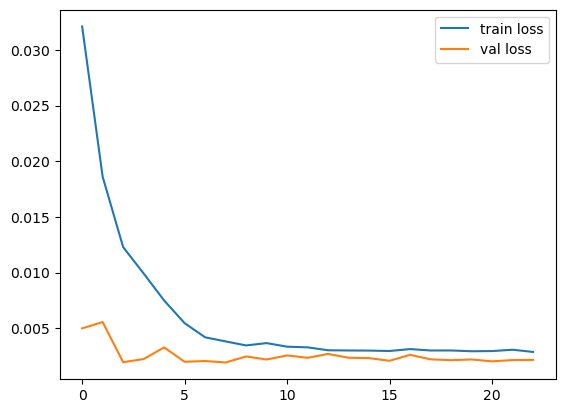

In [27]:
plt.plot(train_loss_per_epoch[1:])
plt.plot(val_loss_per_epoch[1:])
plt.legend(['train loss','val loss'])

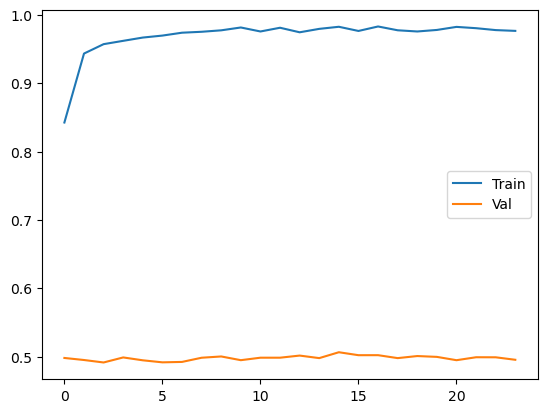

In [28]:
plt.plot(train_winrate)
plt.plot(val_winrate)
plt.legend(['Train','Val'])

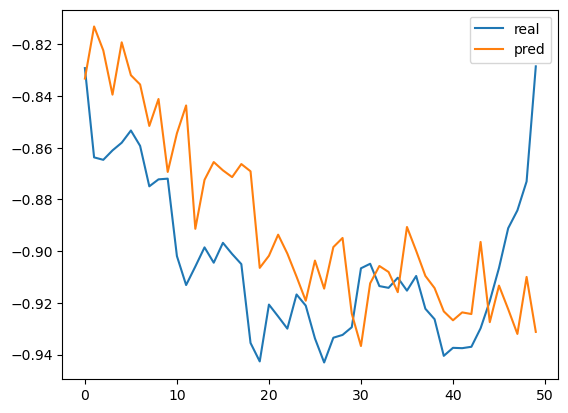

In [29]:
plt.plot(y_val[:50])
plt.plot(predictions1[:50])
plt.legend(['real','pred'])

In [166]:
predictions1 = scaler_star.inverse_transform(predictions1.reshape(-1,1))

In [175]:
y_val = scaler_star.inverse_transform(y_val)

In [177]:
criterion(torch.Tensor(y_val),torch.Tensor(predictions1)).item()

1.3376455307006836

In [181]:
train_loader = DataLoader(train_dataset, batch_size=150, shuffle=False)

model.eval()
predictions2 = []
with torch.no_grad():
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions2.extend(outputs.squeeze().tolist())
predictions2 = np.array(predictions2)

In [182]:
winrate(y_train.reshape(-1,), predictions2)

0.7129111266620014

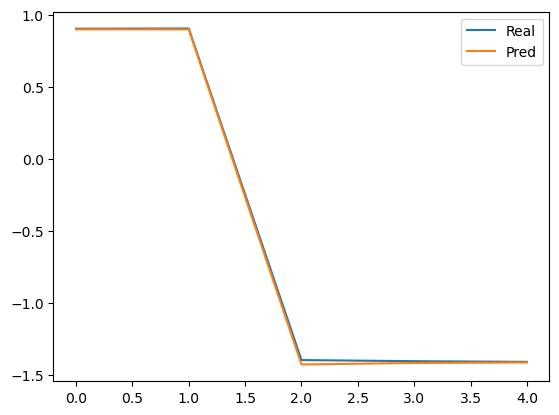

In [192]:
plt.plot(y_train[4164:4169])
plt.plot(predictions2[4164:4169])
plt.legend(['Real','Pred'])

In [193]:
y_train = scaler_star.inverse_transform(y_train)

In [194]:
predictions2 = scaler_star.inverse_transform(predictions2.reshape(-1,1))

In [195]:
criterion(torch.Tensor(y_train), torch.Tensor(predictions2))

tensor(1.1886)

In [196]:
torch.save(model.state_dict(), f'ЧВЕСА/[34,57,1,0.1,1]TSMixer(M F=TI) 1D|W=0.6877, TL=1.1886 VL=1.3376' )